# ML Model 01: Linear Regression (OLS vs Ridge vs Lasso)\n
\n
This notebook trains and evaluates **linear regression models** on the exported feature dataset in `dataset/features/all_features.parquet`.\n
\n
## Goal\n
Predict **next-day return** (1D forward return) using the full feature set exported by `notebooks/Feature_Extraction.ipynb`.\n
\n
## Workflow (aligned to `06_machine_learning_process`)\n
1) Define the objective/metric\n
2) Load and validate feature data\n
3) Define target/labels (forward return)\n
4) Split dataset (asset-based train/val/test)\n
5) Feature diagnostics (mutual information; no feature selection yet)\n
6) Build pipelines (impute -> scale -> model)\n
7) Train models\n
8) Validate + tune regularization (time-aware CV by date)\n
9) Final test evaluation (held-out assets)\n
10) Error analysis notes (bias/variance indicators)\n
\n
## Split policy (asset-first)\n
You requested **75 assets train / 15 assets validation / 15 assets test**. This dataset currently contains **100 assets** (`Asset_001`..`Asset_100`).\n
To preserve the intended 75/15 split while using the full dataset, this notebook uses: **75 train / 15 validation / 10 test** (test count = remaining assets).\n
\n
If/when you expand to >=105 assets, you can change `N_TEST_ASSETS` to 15 without changing the rest of the pipeline.\n

In [1]:
import os
from dataclasses import dataclass

import numpy as np
import pandas as pd
from IPython.display import display
from scipy.stats import spearmanr

from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [2]:
# Reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Data
FEATURES_PARQUET_PATH = '../dataset/features/all_features.parquet'
FEATURES_CSV_PATH = '../dataset/features/all_features.csv'

# Target: next-day return (forward 1D return)
TARGET_COL = 'ret_1d'
TARGET_FWD_COL = 'y_ret_1d_fwd'

# Asset split counts
N_TRAIN_ASSETS = 75
N_VAL_ASSETS = 15
N_TEST_ASSETS = None  # If None, use all remaining assets as test

# Time-aware CV (by unique dates) used for alpha tuning
N_DATE_FOLDS = 5

# Alpha grid for Ridge/Lasso (coarse grid; refine later if needed)
ALPHA_GRID = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

# Output (predictions can be consumed by later backtesting notebooks)
OUTPUT_DIR = 'dataset/model_outputs/linear_models_01'
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [3]:
# Load dataset
if os.path.exists(FEATURES_PARQUET_PATH):
    df = pd.read_parquet(FEATURES_PARQUET_PATH)
    # Support both formats: Date as index (older) or Date as a column (CSV->Parquet conversion).
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
elif os.path.exists(FEATURES_CSV_PATH):
    df = pd.read_csv(FEATURES_CSV_PATH, parse_dates=['Date']).set_index('Date')
else:
    raise FileNotFoundError('Feature dataset not found. Expected Parquet or CSV export under dataset/features/.')

# Basic validation
required_cols = {'Asset_ID', TARGET_COL}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f'Missing required columns in feature dataset: {sorted(missing)}')

df = df.sort_index()
print('shape:', df.shape)
print('index:', type(df.index), df.index.name)
print('assets:', df['Asset_ID'].nunique())
display(df.head(3))


shape: (251100, 122)
index: <class 'pandas.DatetimeIndex'> Date
assets: 100


,ret_1d,logret_1d,excess_ret_1d,logret_lag_1,logret_lag_5,ret_lag_1,ret_lag_5,ret_5d,ret_21d,logret_5d,...,filt_logret_spectral_0p1,filt_close_lms_mu1e-4_taps5,filt_resid_lms_mu1e-4_taps5,filt_logret_lms_mu1e-4_taps5,filt_close_lattice_demo,filt_resid_lattice_demo,filt_logret_lattice_demo,close,volume,Asset_ID
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,28.580592,0.0,NaN,28.580592,0.0,NaN,28.580592,249449990.0,Asset_001
2016-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.489112,0.0,NaN,8.489112,0.0,NaN,8.489112,148653644.0,Asset_028
2016-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,23.826383,0.0,NaN,23.826383,0.0,NaN,23.826383,65904403.0,Asset_029


In [4]:
# Create forward-looking label (next-day return) per asset
df = df.copy()
df[TARGET_FWD_COL] = df.groupby('Asset_ID', sort=False)[TARGET_COL].shift(-1)

# Drop rows where target is missing (last date per asset, plus early NaNs in ret_1d)
df = df.dropna(subset=[TARGET_FWD_COL])

print('shape after label:', df.shape)
display(df[[TARGET_COL, TARGET_FWD_COL, 'Asset_ID']].head(5))


shape after label: (251000, 123)


,ret_1d,y_ret_1d_fwd,Asset_ID
Date,,,
2016-01-25,NaN,0.005531,Asset_001
2016-01-25,NaN,0.027007,Asset_028
2016-01-25,NaN,0.023737,Asset_029
2016-01-25,NaN,0.010319,Asset_030
2016-01-25,NaN,-0.004676,Asset_031


In [5]:
# Asset-based split (deterministic)
assets = sorted(df['Asset_ID'].unique())
if N_TRAIN_ASSETS + N_VAL_ASSETS > len(assets):
    raise ValueError(f'Not enough assets: have {len(assets)} but requested train+val={N_TRAIN_ASSETS+N_VAL_ASSETS}.')

n_test = (len(assets) - N_TRAIN_ASSETS - N_VAL_ASSETS) if (N_TEST_ASSETS is None) else N_TEST_ASSETS
if N_TRAIN_ASSETS + N_VAL_ASSETS + n_test > len(assets):
    raise ValueError('Requested split exceeds available assets.')

train_assets = assets[:N_TRAIN_ASSETS]
val_assets = assets[N_TRAIN_ASSETS:N_TRAIN_ASSETS + N_VAL_ASSETS]
test_assets = assets[N_TRAIN_ASSETS + N_VAL_ASSETS:N_TRAIN_ASSETS + N_VAL_ASSETS + n_test]

print('n_assets:', len(assets))
print('train:', len(train_assets), train_assets[:3], '...', train_assets[-3:])
print('val:', len(val_assets), val_assets[:3], '...', val_assets[-3:])
print('test:', len(test_assets), test_assets[:3], '...', test_assets[-3:])

df_train = df[df['Asset_ID'].isin(train_assets)].copy()
df_val = df[df['Asset_ID'].isin(val_assets)].copy()
df_test = df[df['Asset_ID'].isin(test_assets)].copy()

print('rows train/val/test:', df_train.shape[0], df_val.shape[0], df_test.shape[0])


n_assets: 100
train: 75 ['Asset_001', 'Asset_002', 'Asset_003'] ... ['Asset_073', 'Asset_074', 'Asset_075']
val: 15 ['Asset_076', 'Asset_077', 'Asset_078'] ... ['Asset_088', 'Asset_089', 'Asset_090']
test: 10 ['Asset_091', 'Asset_092', 'Asset_093'] ... ['Asset_098', 'Asset_099', 'Asset_100']
rows train/val/test: 188250 37650 25100


In [6]:
# Feature matrix definition: use all numeric exported features + raw context columns.
# Exclude identifiers and the forward label.
exclude_cols = {'Asset_ID', TARGET_FWD_COL}
feature_cols = [c for c in df.columns if c not in exclude_cols]

# Keep only numeric features for sklearn linear models
numeric_feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]

print('n_features_total:', len(feature_cols))
print('n_features_numeric:', len(numeric_feature_cols))
print('example features:', numeric_feature_cols[:10])

def to_xy(d: pd.DataFrame):
    # Replace inf/-inf with NaN so the imputer can handle them inside pipelines.
    X = d.loc[:, numeric_feature_cols].replace([np.inf, -np.inf], np.nan)
    y = d.loc[:, TARGET_FWD_COL]
    return X, y

X_train, y_train = to_xy(df_train)
X_val, y_val = to_xy(df_val)
X_test, y_test = to_xy(df_test)

print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_val:', X_val.shape, 'y_val:', y_val.shape)
print('X_test:', X_test.shape, 'y_test:', y_test.shape)


n_features_total: 121
n_features_numeric: 121
example features: ['ret_1d', 'logret_1d', 'excess_ret_1d', 'logret_lag_1', 'logret_lag_5', 'ret_lag_1', 'ret_lag_5', 'ret_5d', 'ret_21d', 'logret_5d']
X_train: (188250, 121) y_train: (188250,)
X_val: (37650, 121) y_val: (37650,)
X_test: (25100, 121) y_test: (25100,)


## Feature diagnostics: Mutual Information (MI)\n
We compute MI on the **training split only** to avoid leakage. This is for documentation and intuition only; we still train on **all features** for now.\n

In [7]:
# Mutual information is expensive; subsample rows for speed while preserving time ordering
mi_sample_size = min(50_000, X_train.shape[0])
sample_idx = rng.choice(X_train.shape[0], size=mi_sample_size, replace=False)

X_mi = X_train.iloc[sample_idx].replace([np.inf, -np.inf], np.nan)
y_mi = y_train.iloc[sample_idx]

# SimpleImputer ensures MI can run (handles NaNs).
X_mi_imp = SimpleImputer(strategy='median').fit_transform(X_mi)
mi = mutual_info_regression(X_mi_imp, y_mi.to_numpy(), random_state=SEED)
mi_s = pd.Series(mi, index=numeric_feature_cols).sort_values(ascending=False)
display(mi_s.head(30).to_frame('mutual_information'))
mi_s.head(200).to_csv(os.path.join(OUTPUT_DIR, 'mutual_information_top200.csv'))
print('wrote:', os.path.join(OUTPUT_DIR, 'mutual_information_top200.csv'))


,mutual_information
logret_roll_std_10,0.064967
realized_vol_20,0.063983
logret_roll_std_20,0.063970
logret_roll_var_20,0.063111
logret_roll_var_10,0.060930
logret_roll_var_60,0.060806
logret_roll_std_60,0.055697
logret_roll_std_5,0.054123
logret_roll_min_20,0.051504
logret_roll_var_5,0.051153


wrote: dataset/model_outputs/linear_models_01/mutual_information_top200.csv


## Utilities: Metrics and date-based cross-validation\n
For tuning (Ridge/Lasso alpha), we use **time-aware folds** based on unique dates within the training assets.\n

In [8]:
@dataclass(frozen=True)
class RegressionMetrics:
    rmse: float
    mae: float
    r2: float
    spearman_ic: float


def compute_metrics(y_true: pd.Series, y_pred: np.ndarray) -> RegressionMetrics:
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    ic = float(spearmanr(y_true.to_numpy(), y_pred, nan_policy='omit').correlation)
    return RegressionMetrics(rmse=rmse, mae=mae, r2=r2, spearman_ic=ic)


def date_folds(index: pd.DatetimeIndex, n_splits: int) -> list[tuple[np.ndarray, np.ndarray]]:
    """Create expanding-window folds over unique dates.

    We split the unique dates into (n_splits + 1) consecutive blocks.
    Fold i trains on blocks[0:i] and tests on block[i].
"""
    unique_dates = pd.Index(index.unique()).sort_values()
    if len(unique_dates) < 3:
        return []

    n_splits = int(min(n_splits, len(unique_dates) - 1))
    if n_splits < 1:
        return []

    blocks = np.array_split(unique_dates.to_numpy(), n_splits + 1)

    folds: list[tuple[np.ndarray, np.ndarray]] = []
    for i in range(1, len(blocks)):
        train_dates = pd.Index(np.concatenate(blocks[:i]))
        test_dates = pd.Index(blocks[i])
        if len(train_dates) == 0 or len(test_dates) == 0:
            continue
        train_idx = np.flatnonzero(index.isin(train_dates))
        test_idx = np.flatnonzero(index.isin(test_dates))
        if len(test_idx) == 0 or len(train_idx) == 0:
            continue
        folds.append((train_idx, test_idx))
    return folds


train_folds = date_folds(df_train.index, n_splits=N_DATE_FOLDS)
print('n_date_folds:', len(train_folds))
print('example fold sizes:', [(len(tr), len(te)) for tr, te in train_folds[:2]])


n_date_folds: 5
example fold sizes: [(31425, 31425), (62850, 31350)]


## Models\n
We train three models (as separate code cells, per your request):\n
- OLS-like baseline: `LinearRegression`\n
- Regularized: `Ridge` (L2)\n
- Regularized: `Lasso` (L1)\n
\n
All models are wrapped in a pipeline: `median imputation -> standard scaling -> model`.\n

In [9]:
# Cell 1/3: LinearRegression (no regularization)
ols_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('model', LinearRegression()),
    ]
)

ols_pipe.fit(X_train, y_train)

pred_train = ols_pipe.predict(X_train)
pred_val = ols_pipe.predict(X_val)
pred_test = ols_pipe.predict(X_test)

m_train = compute_metrics(y_train, pred_train)
m_val = compute_metrics(y_val, pred_val)
m_test = compute_metrics(y_test, pred_test)

print('OLS train:', m_train)
print('OLS val  :', m_val)
print('OLS test :', m_test)


OLS train: RegressionMetrics(rmse=0.018732144487233687, mae=0.012309561502184405, r2=0.02250213478449703, spearman_ic=0.043737510599328996)
OLS val  : RegressionMetrics(rmse=0.017870179377357874, mae=0.012034240852275656, r2=0.025324888071488805, spearman_ic=0.03062158014934404)
OLS test : RegressionMetrics(rmse=0.019439423361663745, mae=0.01294762533808818, r2=0.022532145043224983, spearman_ic=0.03721660583245549)


In [10]:
# Cell 2/3: Ridge regression (L2) with alpha tuning using date-based folds
def tune_alpha_ridge(alpha_grid: list[float]) -> tuple[float, pd.DataFrame]:
    rows = []
    for a in alpha_grid:
        pipe = Pipeline(
            steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', Ridge(alpha=a, random_state=SEED)),
            ]
        )
        fold_rmses = []
        for tr_idx, te_idx in train_folds:
            X_tr = X_train.iloc[tr_idx]
            y_tr = y_train.iloc[tr_idx]
            X_te = X_train.iloc[te_idx]
            y_te = y_train.iloc[te_idx]
            pipe.fit(X_tr, y_tr)
            pred = pipe.predict(X_te)
            fold_rmses.append(float(np.sqrt(mean_squared_error(y_te, pred))))
        rows.append({'alpha': a, 'cv_rmse_mean': float(np.mean(fold_rmses)), 'cv_rmse_std': float(np.std(fold_rmses))})
    res = pd.DataFrame(rows).sort_values('cv_rmse_mean', ascending=True).reset_index(drop=True)
    best = float(res.iloc[0]['alpha'])
    return best, res

best_alpha_ridge, ridge_cv = tune_alpha_ridge(ALPHA_GRID)
display(ridge_cv)
print('best_alpha_ridge:', best_alpha_ridge)
ridge_cv.to_csv(os.path.join(OUTPUT_DIR, 'ridge_alpha_cv.csv'), index=False)

ridge_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=best_alpha_ridge, random_state=SEED)),
    ]
)
ridge_pipe.fit(X_train, y_train)

pred_train = ridge_pipe.predict(X_train)
pred_val = ridge_pipe.predict(X_val)
pred_test = ridge_pipe.predict(X_test)

print('Ridge train:', compute_metrics(y_train, pred_train))
print('Ridge val  :', compute_metrics(y_val, pred_val))
print('Ridge test :', compute_metrics(y_test, pred_test))


,alpha,cv_rmse_mean,cv_rmse_std
0,100.0000,0.019663,0.002902
1,10.0000,0.019686,0.002925
2,0.0001,0.019696,0.002950
3,0.0010,0.019697,0.002948
4,1.0000,0.019697,0.002940
5,0.0100,0.019699,0.002945
6,0.1000,0.019700,0.002944


best_alpha_ridge: 100.0
Ridge train: RegressionMetrics(rmse=0.018745517890704565, mae=0.01231111593485162, r2=0.02110591026198272, spearman_ic=0.04005241646200005)
Ridge val  : RegressionMetrics(rmse=0.0178916227011102, mae=0.012036961317519431, r2=0.022984361635814632, spearman_ic=0.02830928749943255)
Ridge test : RegressionMetrics(rmse=0.019460589094739075, mae=0.012957226840660646, r2=0.020402443316424046, spearman_ic=0.031683282014953726)


In [11]:
# Cell 3/3: Lasso regression (L1) with alpha tuning using date-based folds
def tune_alpha_lasso(alpha_grid: list[float]) -> tuple[float, pd.DataFrame]:
    rows = []
    for a in alpha_grid:
        pipe = Pipeline(
            steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', Lasso(alpha=a, random_state=SEED, max_iter=10_000)),
            ]
        )
        fold_rmses = []
        for tr_idx, te_idx in train_folds:
            X_tr = X_train.iloc[tr_idx]
            y_tr = y_train.iloc[tr_idx]
            X_te = X_train.iloc[te_idx]
            y_te = y_train.iloc[te_idx]
            pipe.fit(X_tr, y_tr)
            pred = pipe.predict(X_te)
            fold_rmses.append(float(np.sqrt(mean_squared_error(y_te, pred))))
        rows.append({'alpha': a, 'cv_rmse_mean': float(np.mean(fold_rmses)), 'cv_rmse_std': float(np.std(fold_rmses))})
    res = pd.DataFrame(rows).sort_values('cv_rmse_mean', ascending=True).reset_index(drop=True)
    best = float(res.iloc[0]['alpha'])
    return best, res

best_alpha_lasso, lasso_cv = tune_alpha_lasso(ALPHA_GRID)
display(lasso_cv)
print('best_alpha_lasso:', best_alpha_lasso)
lasso_cv.to_csv(os.path.join(OUTPUT_DIR, 'lasso_alpha_cv.csv'), index=False)

lasso_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', Lasso(alpha=best_alpha_lasso, random_state=SEED, max_iter=10_000)),
    ]
)
lasso_pipe.fit(X_train, y_train)

pred_train = lasso_pipe.predict(X_train)
pred_val = lasso_pipe.predict(X_val)
pred_test = lasso_pipe.predict(X_test)

print('Lasso train:', compute_metrics(y_train, pred_train))
print('Lasso val  :', compute_metrics(y_val, pred_val))
print('Lasso test :', compute_metrics(y_test, pred_test))


,alpha,cv_rmse_mean,cv_rmse_std
0,0.1000,0.019516,0.002945
1,0.0100,0.019516,0.002945
2,10.0000,0.019516,0.002945
3,1.0000,0.019516,0.002945
4,100.0000,0.019516,0.002945
5,0.0010,0.019527,0.002940
6,0.0001,0.019563,0.002883


best_alpha_lasso: 0.1
Lasso train: RegressionMetrics(rmse=0.018946526000414916, mae=0.012316601143005666, r2=0.0, spearman_ic=nan)
Lasso val  : RegressionMetrics(rmse=0.018101186960266604, mae=0.012035154499652341, r2=-3.72126660275196e-05, spearman_ic=nan)
Lasso test : RegressionMetrics(rmse=0.019662545780156013, mae=0.012961715128710548, r2=-3.5049102192541426e-05, spearman_ic=nan)


/tmp/ipykernel_173472/3162983942.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = float(spearmanr(y_true.to_numpy(), y_pred, nan_policy='omit').correlation)
/tmp/ipykernel_173472/3162983942.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = float(spearmanr(y_true.to_numpy(), y_pred, nan_policy='omit').correlation)
/tmp/ipykernel_173472/3162983942.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = float(spearmanr(y_true.to_numpy(), y_pred, nan_policy='omit').correlation)


## Light bias/variance signal (asset-count learning curve)\n
This is a simple diagnostic: keep the **validation assets fixed** and vary how many **training assets** are used. If validation error drops and then rises as training set grows, that often indicates instability/leakage; if it drops and plateaus, the model benefits from more data.\n

,n_train_assets,train_rmse,val_rmse
0,10,0.022308,0.017990
1,25,0.018982,0.017912
2,50,0.019064,0.017905
3,75,0.018746,0.017892


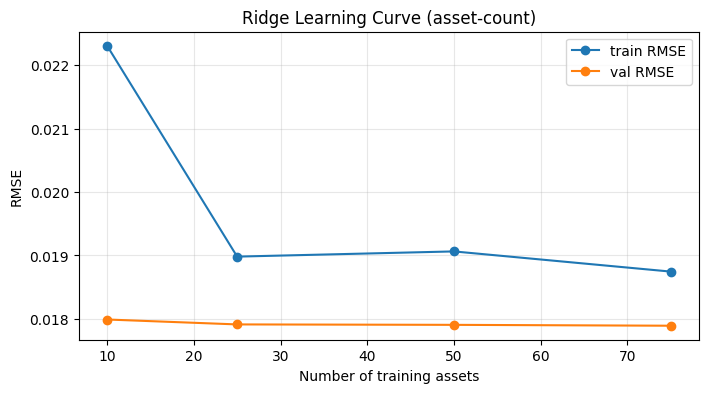

In [12]:
import matplotlib.pyplot as plt

def subset_by_assets(frame: pd.DataFrame, asset_list: list[str]) -> pd.DataFrame:
    return frame[frame['Asset_ID'].isin(asset_list)].copy()

train_asset_counts = [10, 25, 50, len(train_assets)]
curve = []
for n in train_asset_counts:
    sub_assets = train_assets[:n]
    sub = subset_by_assets(df_train, sub_assets)
    X_sub, y_sub = to_xy(sub)
    # Use ridge with tuned alpha as a representative regularized model
    ridge_pipe.fit(X_sub, y_sub)
    pred_sub_tr = ridge_pipe.predict(X_sub)
    pred_sub_val = ridge_pipe.predict(X_val)
    curve.append({
        'n_train_assets': n,
        'train_rmse': float(np.sqrt(mean_squared_error(y_sub, pred_sub_tr))),
        'val_rmse': float(np.sqrt(mean_squared_error(y_val, pred_sub_val))),
    })

curve_df = pd.DataFrame(curve)
display(curve_df)
curve_df.to_csv(os.path.join(OUTPUT_DIR, 'ridge_learning_curve_by_assets.csv'), index=False)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(curve_df['n_train_assets'], curve_df['train_rmse'], marker='o', label='train RMSE')
ax.plot(curve_df['n_train_assets'], curve_df['val_rmse'], marker='o', label='val RMSE')
ax.set_xlabel('Number of training assets')
ax.set_ylabel('RMSE')
ax.set_title('Ridge Learning Curve (asset-count)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


## Export predictions for backtesting\n
We write predictions joined with `Date` and `Asset_ID` so they can be ingested by later backtesting notebooks.\n

In [13]:
def export_preds(frame: pd.DataFrame, pipe: Pipeline, name: str) -> str:
    X, y = to_xy(frame)
    out = pd.DataFrame({
        'Date': frame.index,
        'Asset_ID': frame['Asset_ID'].to_numpy(),
        'y_true': y.to_numpy(),
        'y_pred': pipe.predict(X),
    })
    out_path = os.path.join(OUTPUT_DIR, f'preds_{name}.parquet')
    out.to_parquet(out_path, index=False)
    return out_path

paths = {
    'ols_val': export_preds(df_val, ols_pipe, 'ols_val'),
    'ols_test': export_preds(df_test, ols_pipe, 'ols_test'),
    'ridge_val': export_preds(df_val, ridge_pipe, 'ridge_val'),
    'ridge_test': export_preds(df_test, ridge_pipe, 'ridge_test'),
    'lasso_val': export_preds(df_val, lasso_pipe, 'lasso_val'),
    'lasso_test': export_preds(df_test, lasso_pipe, 'lasso_test'),
}
paths


{'ols_val': 'dataset/model_outputs/linear_models_01/preds_ols_val.parquet',
 'ols_test': 'dataset/model_outputs/linear_models_01/preds_ols_test.parquet',
 'ridge_val': 'dataset/model_outputs/linear_models_01/preds_ridge_val.parquet',
 'ridge_test': 'dataset/model_outputs/linear_models_01/preds_ridge_test.parquet',
 'lasso_val': 'dataset/model_outputs/linear_models_01/preds_lasso_val.parquet',
 'lasso_test': 'dataset/model_outputs/linear_models_01/preds_lasso_test.parquet'}

backtest_assets: 10 ['Asset_091', 'Asset_092', 'Asset_093'] ... ['Asset_098', 'Asset_099', 'Asset_100']


Loading BokehJS ...

,model,Total Return [%],CAGR [%],Sharpe,Max Drawdown [%]
0,ridge,376.060874,16.959697,0.894865,-38.488000
1,lasso,366.072616,16.710969,0.925644,-35.774485
2,ols,329.067653,15.745624,0.841571,-37.055931


best_model_by_1N_total_return: ridge Total Return [%]: 376.0608744011958


,Linear Model (ridge) - Original Style 1N
Start,2016-01-25 00:00:00
End,2026-01-16 00:00:00
Duration,3644 days 00:00:00
Initial Equity,1000000.0
Final Equity,4760608.744012
Equity Peak,4782795.775642
Total Return [%],376.060874
CAGR [%],16.959697
Volatility (ann) [%],19.705881
Sharpe,0.894865


,Linear Model (ridge) - Original Style MPT
Start,2016-01-25 00:00:00
End,2026-01-16 00:00:00
Duration,3644 days 00:00:00
Initial Equity,1000000.0
Final Equity,5082909.451176
Equity Peak,5099834.515544
Total Return [%],408.290945
CAGR [%],17.731467
Volatility (ann) [%],19.402404
Sharpe,0.938796


Starting actor-based backtest (MPT weights)...


100%|██████████| 2511/2511 [01:44<00:00, 24.14it/s]


Actor backtest finished.


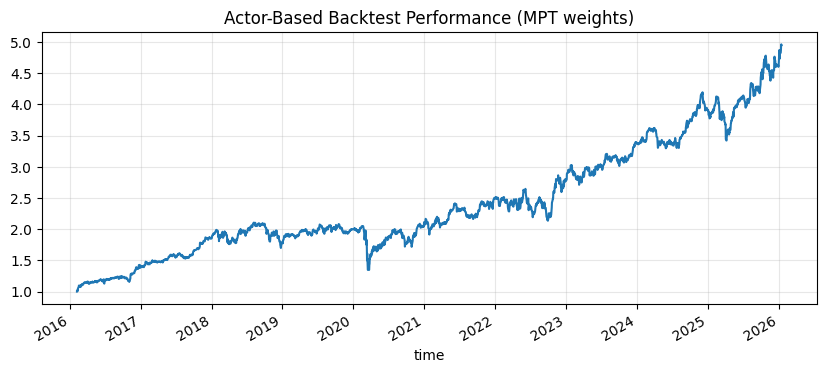

Actor Final Portfolio Value: 4946733.791683729
Actor Total Return [%]: 394.6733791683731


: 

In [ ]:
# --- Backtesting: Original Style (1N + MPT) and Actor-Based ---
#
# This section runs the *final* linear model through: 
# - Original Style 1N (equal-weight Top-K) backtester
# - Original Style MPT (mean-variance optimized Top-K) backtester
# - Actor-based backtester (trade-engine), using the MPT target weights as orders
#
# Universe: held-out test assets only (asset-first split policy).

from pathlib import Path
import sys
import uuid

import numpy as np
import pandas as pd

from bokeh.io import output_notebook, show

from sqlalchemy import create_engine, StaticPool

CWD = Path.cwd()
PROJECT_ROOT = CWD.parent if CWD.name == 'notebooks' else CWD
sys.path.append(str(PROJECT_ROOT))

from src.backtester.data import load_cleaned_assets, align_close_prices
from src.backtester.engine import BacktestConfig, run_backtest
from src.backtester.report import compute_backtest_report
from src.backtester.bokeh_plots import build_interactive_portfolio_layout
from src.backtester.portfolio import equal_weight, optimize_mpt

# trade-engine (actor backtester)
engine_root = (PROJECT_ROOT / 'another_testing_engine' / 'trade-engine' / 'trade-engine').resolve()
if str(engine_root) not in sys.path:
    sys.path.append(str(engine_root))

from tradeengine.actors.memory import MemPortfolioActor
from tradeengine.actors.sql import SQLOrderbookActor
from tradeengine.backtest import BacktestStrategy

import matplotlib.pyplot as plt

# Candidate linear models (same split, same features)
candidate_pipes = {
    'ols': ols_pipe,
    'ridge': ridge_pipe,
    'lasso': lasso_pipe,
}

def prediction_matrix_for_pipe(pipe) -> pd.DataFrame:
    pred = pipe.predict(X_test)
    long = pd.DataFrame({'Date': df_test.index, 'Asset_ID': df_test['Asset_ID'].to_numpy(), 'y_pred': pred})
    return long.pivot_table(index='Date', columns='Asset_ID', values='y_pred', aggfunc='mean').sort_index()

pred_mats = {name: prediction_matrix_for_pipe(pipe) for name, pipe in candidate_pipes.items()}
bt_assets = sorted(next(iter(pred_mats.values())).columns.tolist())
print('backtest_assets:', len(bt_assets), bt_assets[:3], '...', bt_assets[-3:])

# Load OHLCV for the same asset universe
assets_ohlcv = load_cleaned_assets(symbols=bt_assets, cleaned_dir=str(PROJECT_ROOT / 'dataset' / 'cleaned'))
close_prices = align_close_prices(assets_ohlcv)
returns_matrix = close_prices.pct_change().fillna(0.0)

# Market proxy OHLCV for the portfolio Bokeh dashboard
market_df = pd.DataFrame({
    'Open': pd.concat([df['Open'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'High': pd.concat([df['High'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'Low': pd.concat([df['Low'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'Close': pd.concat([df['Close'] for df in assets_ohlcv.values()], axis=1).mean(axis=1),
    'Volume': pd.concat([df['Volume'] for df in assets_ohlcv.values()], axis=1).sum(axis=1),
}).sort_index()

# Align prediction matrices to the available price calendar
pred_mats = {k: v.reindex(close_prices.index) for k, v in pred_mats.items()}

output_notebook()

REBALANCE_FREQ = 'W'
TOP_K = min(20, len(bt_assets))
LOOKBACK_DAYS = 126

def build_weights_from_predictions(pred_matrix: pd.DataFrame, *, pm_style: str) -> pd.DataFrame:
    # Use last *trading day* of each rebalance period (not the period label like Sunday).
    rebal_dates = set(pd.Series(pred_matrix.index, index=pred_matrix.index).resample(REBALANCE_FREQ).last().dropna().tolist())
    w_last = pd.Series(0.0, index=bt_assets)
    w_rows = []
    for dt in pred_matrix.index:
        if dt in rebal_dates:
            row = pred_matrix.loc[dt].dropna().sort_values(ascending=False)
            top = row.head(TOP_K)
            candidates = [a for a, v in top.items() if np.isfinite(v) and v > 0]
            if len(candidates) == 0:
                w_last = pd.Series(0.0, index=bt_assets)
            else:
                if pm_style == '1N':
                    w_dict = equal_weight(candidates)
                elif pm_style == 'MPT':
                    w_dict = optimize_mpt(returns_matrix, candidates, dt, lookback_days=LOOKBACK_DAYS)
                else:
                    raise ValueError(f'Unknown pm_style: {pm_style!r}')
                w_last = pd.Series(0.0, index=bt_assets)
                for a, w in w_dict.items():
                    if a in w_last.index:
                        w_last[a] = float(w)
        w_rows.append(w_last)
    weights = pd.DataFrame(w_rows, index=pred_matrix.index, columns=bt_assets).fillna(0.0)
    return weights

cfg_vec = BacktestConfig(initial_equity=1_000_000.0, transaction_cost_bps=5.0, mode='vectorized')

# Run Original Style 1/N for all 3 models (lightweight) and select best by Total Return
rows = []
best_model_name = None
best_total_return = -np.inf
best_pred_matrix = None

for model_name, pm in pred_mats.items():
    w_1n_tmp = build_weights_from_predictions(pm, pm_style='1N')
    res_tmp = run_backtest(close_prices, w_1n_tmp, config=cfg_vec)
    rpt_tmp = compute_backtest_report(result=res_tmp, close_prices=close_prices)
    tr = float(rpt_tmp['Total Return [%]'])
    rows.append({
        'model': model_name,
        'Total Return [%]': tr,
        'CAGR [%]': float(rpt_tmp['CAGR [%]']),
        'Sharpe': float(rpt_tmp['Sharpe']),
        'Max Drawdown [%]': float(rpt_tmp['Max Drawdown [%]']),
    })
    if tr > best_total_return:
        best_total_return = tr
        best_model_name = str(model_name)
        best_pred_matrix = pm

compare = pd.DataFrame(rows).sort_values('Total Return [%]', ascending=False).reset_index(drop=True)
display(compare)
print('best_model_by_1N_total_return:', best_model_name, 'Total Return [%]:', best_total_return)

pred_matrix = best_pred_matrix
weights_1n = build_weights_from_predictions(pred_matrix, pm_style='1N')
weights_mpt = build_weights_from_predictions(pred_matrix, pm_style='MPT')

def run_and_report(weights: pd.DataFrame, title: str):
    res = run_backtest(close_prices, weights, config=cfg_vec)
    report = compute_backtest_report(result=res, close_prices=close_prices)
    display(report.to_frame(title))
    layout = build_interactive_portfolio_layout(
        market_ohlcv=market_df,
        equity=res.equity,
        returns=res.returns,
        weights=res.weights,
        turnover=res.turnover,
        costs=res.costs,
        close_prices=close_prices,
        title=title,
    )
    show(layout)
    return res, report

_res_1n, _rpt_1n = run_and_report(weights_1n, f'Linear Model ({best_model_name}) - Original Style 1N')
_res_mpt, _rpt_mpt = run_and_report(weights_mpt, f'Linear Model ({best_model_name}) - Original Style MPT')

# Actor-based backtest: convert MPT weights into TargetWeight orders on rebalance dates
def weights_to_formatted_signals(w: pd.DataFrame) -> dict[str, pd.Series]:
    # Convert to trading-day timestamps (actor engine requires timestamps to exist in market data index).
    rebal_dates = pd.Series(w.index, index=w.index).resample(REBALANCE_FREQ).last().dropna().tolist()
    active: set[str] = set()
    sig: dict[str, dict[pd.Timestamp, dict]] = {a: {} for a in w.columns}
    for dt in rebal_dates:
        if dt not in w.index:
            continue
        row = w.loc[dt]
        # Close removed positions
        for a in list(active):
            if float(row.get(a, 0.0)) <= 0.0:
                sig[a][dt] = {'CloseOrder': {}}
                active.remove(a)
        # Set target weights for active positions
        for a, weight in row.items():
            if float(weight) > 0.0:
                sig[a][dt] = {'TargetWeightOrder': {'size': float(weight)}}
                active.add(str(a))

    formatted: dict[str, pd.Series] = {}
    for a, d in sig.items():
        if d:
            s = pd.Series(d)
            s.index = pd.to_datetime(s.index)
            formatted[a] = s.sort_index()
        else:
            formatted[a] = pd.Series(dtype=object)
    return formatted

formatted_signals = weights_to_formatted_signals(weights_mpt)
quote_frames = {a: assets_ohlcv[a][['Open', 'High', 'Low', 'Close']] for a in bt_assets}

fund_value = 1_000_000.0
portfolio_actor = MemPortfolioActor.start(funding=fund_value)
db_engine = create_engine('sqlite://', echo=False, connect_args={'check_same_thread': False}, poolclass=StaticPool)
orderbook_actor = SQLOrderbookActor.start(portfolio_actor, db_engine, strategy_id=str(uuid.uuid4()))

print('Starting actor-based backtest (MPT weights)...')
bt_strategy = BacktestStrategy(orderbook_actor, portfolio_actor, quote_frames)
actor_result = bt_strategy.run_backtest(formatted_signals)
print('Actor backtest finished.')

perf = actor_result.porfolio_performance
fig, ax = plt.subplots(figsize=(10, 4))
perf['performance'].plot(ax=ax, title='Actor-Based Backtest Performance (MPT weights)')
ax.grid(True, alpha=0.3)
plt.show()
print('Actor Final Portfolio Value:', float(perf['value'].iloc[-1]))
print('Actor Total Return [%]:', float((perf['performance'].iloc[-1] - 1) * 100.0))
